In [1]:
import tensorflow as tf
import csv
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize

In [2]:
%matplotlib inline

### Reading the CSV file and cleaning

feature dataframe has the features read except for the first (seq_num) and the last column (label)
The dataframe also drop the Glucose column and replaces all NaN values and 7,9 (in labels) to 0

Features were also normalized - (features - features.mean())/features.std()

In [12]:
df = pd.read_csv('../Data/new_nhanes.csv')
df = df.iloc[:, 1:]

# replace string values with integers
df['Gender'] = df['Gender'].map({'female': 1, 'male': 0})
df['Diabetes'] = df['Diabetes'].map({'Yes': 1, 'No': 0})

# dropping all NaN in the dataframe
df = df.dropna(axis=0, how='any')

print "Cleaned label counts:"
print df.groupby('Diabetes').size()

#separating features and labels
features = df.iloc[:, 0:-1]
label = df.iloc[:,-1]

print "\n"
print "Columns in the features"
column_names = list(features)
print column_names
# #normalizing features - unnormalized also results in similar results
# normalized_features = (features - features.mean())/features.std()

Cleaned label counts:
Diabetes
0.0    6987
1.0     648
dtype: int64


### Formatting input for Machine Learning

In [13]:
X = features.as_matrix()
# X = normalized_features.as_matrix()

Y = label.as_matrix()

print "Shape of the matrices"
print X.shape
print Y.shape

print "\n"
print "Total unique counts by labels"
print np.unique(Y, return_counts=True)

# Y = label_binarize(Y, classes=[1, 2, 3])

# 70% training and 30% test 
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

print "\n"
print "Total unique counts by labels for training and testing"
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print np.unique(y_train, return_counts=True)
print np.unique(y_test, return_counts=True)

Shape of the matrices
(7635, 8)
(7635,)


Total unique counts by labels
(array([ 0.,  1.]), array([6987,  648]))


Total unique counts by labels for training and testing
(5344, 'train sequences')
(2291, 'test sequences')
(array([ 0.,  1.]), array([4891,  453]))
(array([ 0.,  1.]), array([2096,  195]))


#### Comparision with Decision Trees and Random Forest 
RF number of trees - 50


Decision Tree
             precision    recall  f1-score   support

   Daibetic       0.96      0.96      0.96      2096
     Normal       0.54      0.56      0.55       195

avg / total       0.92      0.92      0.92      2291

Confusion matrix, without normalization
[[2004   92]
 [  85  110]]


Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix
Accuracy:  0.922741161065
Precision:  0.924008421448
Recall:  0.922741161065


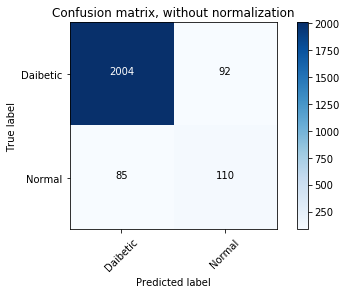

In [15]:
import itertools
from sklearn import tree, linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
# These are the tuned paramters

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def decision_tree(feat_train, feat_test, label_train, label_test):
    clf = tree.DecisionTreeClassifier(class_weight=None,
                                      criterion='gini', splitter='best')
    clf.fit(feat_train, label_train)
    predicted_labels = clf.predict(feat_test)
    label_test = np.array(label_test)
    result = {}
    result['recall'] = recall_score(label_test, predicted_labels,
                                    average='weighted')
    result['accuracy'] = accuracy_score(label_test, predicted_labels)
    result['precision'] = precision_score(label_test, predicted_labels,
                                          average='weighted')
    
    target_names = ['Daibetic', 'Normal']
    
    print(classification_report(label_test, predicted_labels, target_names=target_names))
    
    cnf_matrix = confusion_matrix(label_test, predicted_labels)
    plot_confusion_matrix(cnf_matrix, classes=target_names, title='Confusion matrix, without normalization')
    
    return result['accuracy'], result['precision'], result['recall']

print('Decision Tree')
accuracy,precision,recall = decision_tree(x_train, x_test, y_train, y_test)
print "\n"
print "Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix"
print "Accuracy: ", accuracy
print "Precision: ", precision
print "Recall: ", recall


In [16]:
def random_forest(feat_train, feat_test, label_train, label_test, num_estimators):
    clf = RandomForestClassifier(n_estimators=num_estimators, max_features=None)

    clf.fit(feat_train, label_train)
    predicted_labels = clf.predict(feat_test)
    label_test = np.array(label_test)
    result = {}
    result['recall'] = recall_score(label_test, predicted_labels,
                                    average='weighted')
    result['accuracy'] = accuracy_score(label_test, predicted_labels)
    result['precision'] = precision_score(label_test, predicted_labels,
                                          average='weighted')
    target_names = ['Daibetic', 'Normal']
    
    print(classification_report(label_test, predicted_labels, target_names=target_names))
    
    cnf_matrix = confusion_matrix(label_test, predicted_labels)
    plot_confusion_matrix(cnf_matrix, classes=target_names, title='Confusion matrix, without normalization')
    
    return result['accuracy'], result['precision'], result['recall']

#### Random Forest with 50 trees

Random forest
             precision    recall  f1-score   support

   Daibetic       0.95      0.99      0.97      2096
     Normal       0.78      0.50      0.61       195

avg / total       0.94      0.95      0.94      2291

Confusion matrix, without normalization
[[2069   27]
 [  98   97]]


Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix
Accuracy:  0.945438673069
Precision:  0.940092192585
Recall:  0.945438673069


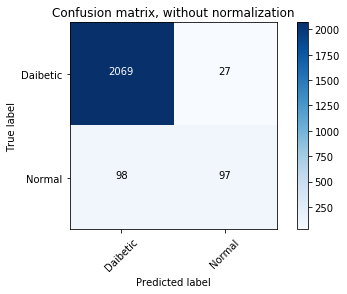

In [17]:
print("Random forest")
accuracy,precision,recall = random_forest(x_train, x_test, y_train, y_test, 50)
print "\n"
print "Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix"
print "Accuracy: ", accuracy
print "Precision: ", precision
print "Recall: ", recall

#### Random Forest with 500 trees

Random forest
             precision    recall  f1-score   support

   Daibetic       0.96      0.99      0.97      2096
     Normal       0.82      0.51      0.63       195

avg / total       0.94      0.95      0.94      2291

Confusion matrix, without normalization
[[2074   22]
 [  96   99]]


Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix
Accuracy:  0.948494107377
Precision:  0.94405027816
Recall:  0.948494107377


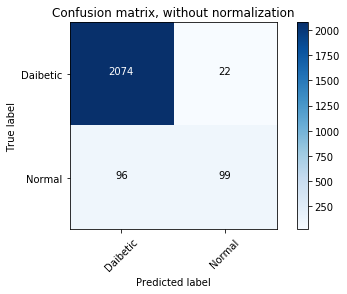

In [18]:
print("Random forest")
accuracy,precision,recall = random_forest(x_train, x_test, y_train, y_test, 500)
print "\n"
print "Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix"
print "Accuracy: ", accuracy
print "Precision: ", precision
print "Recall: ", recall

#### Random Forest with 1000 trees

Random forest
             precision    recall  f1-score   support

   Daibetic       0.96      0.99      0.97      2096
     Normal       0.81      0.51      0.62       195

avg / total       0.94      0.95      0.94      2291

Confusion matrix, without normalization
[[2073   23]
 [  96   99]]


Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix
Accuracy:  0.948057616761
Precision:  0.943460797441
Recall:  0.948057616761


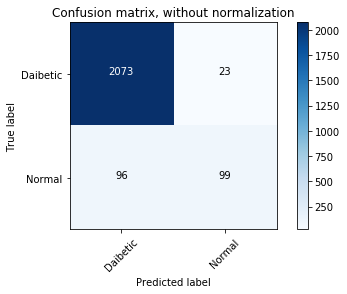

In [19]:
print("Random forest")
accuracy,precision,recall = random_forest(x_train, x_test, y_train, y_test, 1000)
print "\n"
print "Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix"
print "Accuracy: ", accuracy
print "Precision: ", precision
print "Recall: ", recall

#### Random Forest with 10000 trees

Random forest
             precision    recall  f1-score   support

   Daibetic       0.96      0.99      0.97      2096
     Normal       0.81      0.51      0.62       195

avg / total       0.94      0.95      0.94      2291

Confusion matrix, without normalization
[[2073   23]
 [  96   99]]


Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix
Accuracy:  0.948057616761
Precision:  0.943460797441
Recall:  0.948057616761


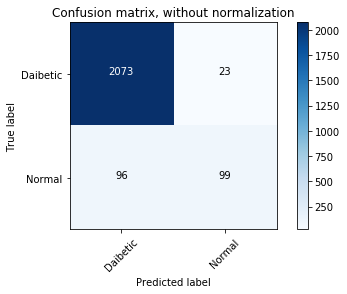

In [20]:
print("Random forest")
accuracy,precision,recall = random_forest(x_train, x_test, y_train, y_test, 10000)
print "\n"
print "Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix"
print "Accuracy: ", accuracy
print "Precision: ", precision
print "Recall: ", recall

Logistic Regression
              precision    recall  f1-score   support

    Daibetic       0.92      0.99      0.96      2096
      Normal       0.56      0.07      0.13       195

 avg / total       0.89      0.92      0.89      2291

Confusion matrix, without normalization
[[2085   11]
 [ 181   14]]


Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix
Accuracy:  0.916193801833
Precision:  0.889471407168
Recall:  0.916193801833


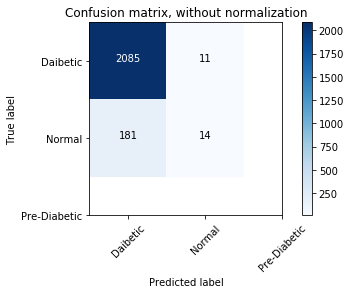

In [21]:
def log_reg(feat_train, feat_test, label_train, label_test):
    clf = linear_model.LogisticRegression()
    clf.fit(feat_train, label_train)
    predicted_labels = clf.predict(feat_test)
    label_test = np.array(label_test)
    result = {}
    result['recall'] = recall_score(label_test, predicted_labels,
                                    average='weighted')
    result['accuracy'] = accuracy_score(label_test, predicted_labels)
    result['precision'] = precision_score(label_test, predicted_labels,
                                          average='weighted')
    
    target_names = ['Daibetic', 'Normal', 'Pre-Diabetic']
    
    print(classification_report(label_test, predicted_labels, target_names=target_names))
    
    cnf_matrix = confusion_matrix(label_test, predicted_labels)
    plot_confusion_matrix(cnf_matrix, classes=target_names, title='Confusion matrix, without normalization')
    
    return result['accuracy'], result['precision'], result['recall']

print('Logistic Regression')
accuracy,precision,recall = log_reg(x_train, x_test, y_train, y_test)
print "\n"
print "Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix"
print "Accuracy: ", accuracy
print "Precision: ", precision
print "Recall: ", recall


SVM
              precision    recall  f1-score   support

    Daibetic       0.95      1.00      0.97      2096
      Normal       1.00      0.38      0.56       195

 avg / total       0.95      0.95      0.94      2291

Confusion matrix, without normalization
[[2096    0]
 [ 120   75]]


Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix
Accuracy:  0.947621126146
Precision:  0.950457527257
Recall:  0.947621126146


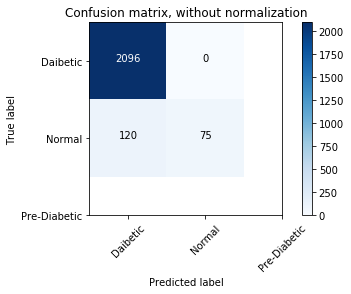

In [22]:
from sklearn.svm import SVC
def svm(feat_train, feat_test, label_train, label_test):
    clf = SVC(gamma=.2)
    clf.fit(feat_train, label_train)
    predicted_labels = clf.predict(feat_test)
    label_test = np.array(label_test)
    result = {}
    result['recall'] = recall_score(label_test, predicted_labels,
                                    average='weighted')
    result['accuracy'] = accuracy_score(label_test, predicted_labels)
    result['precision'] = precision_score(label_test, predicted_labels,
                                          average='weighted')
    
    target_names = ['Daibetic', 'Normal', 'Pre-Diabetic']
    
    print(classification_report(label_test, predicted_labels, target_names=target_names))
    
    cnf_matrix = confusion_matrix(label_test, predicted_labels)
    plot_confusion_matrix(cnf_matrix, classes=target_names, title='Confusion matrix, without normalization')
    
    return result['accuracy'], result['precision'], result['recall']

print('SVM')
accuracy,precision,recall = svm(x_train, x_test, y_train, y_test)
print "\n"
print "Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix"
print "Accuracy: ", accuracy
print "Precision: ", precision
print "Recall: ", recall